# Introducción

El consumo energético es un fenómeno complejo influenciado por múltiples factores temporales, climáticos y operativos. Comprender sus patrones no solo permite describir el comportamiento histórico, sino también anticipar escenarios futuros, optimizar recursos y apoyar la toma de decisiones basada en datos.

En este proyecto se analiza un dataset de consumo energético con el objetivo de identificar patrones relevantes, variables explicativas clave y construir modelos predictivos capaces de estimar el consumo energético. A diferencia del proyecto anterior, este análisis incorpora una etapa formal de modelado estadístico y/o de machine learning, siguiendo una estructura reproducible y orientada a producción.

El proyecto está diseñado para reflejar un flujo de trabajo profesional: exploración → preparación de datos → modelado → evaluación → comunicación de resultados.

------------------------

# Objetivo del proyecto

El objetivo de este proyecto es analizar el comportamiento del consumo energético a partir de datos históricos, identificando patrones temporales, variables que influyen significativamente en el consumo y posibles anomalías, para finalmente desarrollar modelos predictivos que permitan estimar el consumo energético futuro con un balance adecuado entre precisión e interpretabilidad.


-----------------------------------

# Preguntas del análisis
## Preguntas principales

#### 1. ¿Cuáles son los patrones temporales del consumo energético?
- ¿Existen tendencias a largo plazo?
- ¿Se observan patrones diarios, semanales o estacionales?

#### 2. ¿Qué variables explican mayor variabilidad en el consumo energético?
- ¿El consumo está más influenciado por factores temporales, operativos o externos (si existen)?
- ¿Qué variables muestran mayor correlación con el consumo?

#### 3. ¿Existen anomalías o comportamientos atípicos en el consumo?
- ¿Se presentan picos o caídas anómalas?
- ¿Estos eventos pueden asociarse a fechas, horarios o condiciones específicas?

#### 4. ¿Es posible predecir el consumo energético a partir de los datos disponibles?
- ¿Qué tan bien se puede modelar el consumo usando técnicas supervisadas?
- ¿Qué modelo ofrece el mejor balance entre precisión e interpretabilidad?

## Preguntas secundarias (de apoyo al modelado)

#### 1.¿Qué transformaciones de datos mejoran el desempeño del modelo?

- ¿Es necesario escalar, normalizar o transformar variables?

- ¿Las variables temporales requieren ingeniería de características (lags, rolling means)?

#### 2.¿Cómo se comporta el error del modelo a lo largo del tiempo?

- ¿El modelo falla más en ciertos periodos (picos de demanda, fines de semana, estaciones)?

- ¿Existen sesgos sistemáticos en las predicciones?

#### 3.¿Qué variables son más importantes en la predicción del consumo?

- ¿Qué insights se pueden extraer a partir de la interpretación del modelo?

- ¿Coinciden con lo observado en el análisis exploratorio?

----------------------------------------------

# Analisis Exploratorio Inicial.
### Dataset: household_power_consumption
### 1. Carga de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression


---------------------------------------

### 2. Cargar el Dataset
Leemos el archivo `Insurancehousehold_power_consumption.csv` desde la ruta local y mostramos las primeras filas para verificar que se cargó correctamente.

In [36]:
df = pd.read_csv(r"C:\MARIO\PORTAFOLIO\House-power-consumption\household_power_consumption.csv", sep=';', low_memory=False,
    na_values=['?'])
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


---------------------------------------

### 3. Cuantas filas y columnas hay?

In [37]:
df.shape

(2075259, 9)

Este Dataset Contiene, 2.075.259 filas y 9 Columnas

--------------------------------------

### 4. tipos de variables en el Dataset.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


-------------------------------------

### 5. Integraremos las columnas Date y Time en una sola. 

In [39]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

#### 5.1 Eliminamos las columnas Date y Time pues ya no las necesitamos

In [40]:
df = df.drop(['Date', 'Time'], axis=1)

#### 5.2 Reordenamos las columnas para tener datetime al principio del Dataset

In [41]:
cols = ['datetime'] + [col for col in df.columns if col != 'datetime']
df = df[cols]

#### 5.2 Comprobamos el cambio

In [42]:
print(df.dtypes)
df.head()

datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


----------------------------------------

### 6. Verificamos si faltan valores

In [43]:
print(df.isnull().sum())

datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


-------------------------------------------------

### 7. Rellenamos valores faltantes (interpolacion) Ideal para series temporales como es el caso.

In [44]:
# Interpolar solo las columnas numéricas
df[df.select_dtypes(include='number').columns] = df.select_dtypes(include='number').interpolate()

#### 7.1 Validamos el resultado

In [45]:
print(df.isnull().sum())

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


### 8. Verificamos valores negativos

In [46]:
# Lista de columnas numéricas
cols_numericas = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in cols_numericas:
    negativos = (df[col] < 0).sum()
    print(f"{col}: {negativos} valores negativos")

Global_active_power: 0 valores negativos
Global_reactive_power: 0 valores negativos
Voltage: 0 valores negativos
Global_intensity: 0 valores negativos
Sub_metering_1: 0 valores negativos
Sub_metering_2: 0 valores negativos
Sub_metering_3: 0 valores negativos


-----------------------------------------------------------------------

### 9. Eliminamos duplicados si existen

In [47]:
duplicados = df.duplicated().sum()
if duplicados > 0:
    df = df.drop_duplicates()
    print(f"Se eliminaron {duplicados} filas duplicadas.")
else:
    print("No se encontraron filas duplicadas.")

No se encontraron filas duplicadas.


----------------------------------------------------

### 10. guardamos el Dataset Limpio en la carpeta "Processed" del proyecto.

In [48]:
df.to_csv("C:/MARIO/PORTAFOLIO/2-Analisis-consumo-energetico/data/processed/consumo_energetico_limpio.csv", index=False)


--------------------------------------

### 11. Análisis inicial de la serie temporal

El gráfico muestra la evolución del consumo energético a lo largo del tiempo. Esta visualización permite identificar tendencias generales, variabilidad del consumo y la posible presencia de comportamientos atípicos, como picos o caídas abruptas. Asimismo, ofrece una primera aproximación a la existencia de patrones temporales que serán analizados con mayor detalle mediante agregaciones y descomposición de la serie.


In [11]:
df2 = pd.read_csv("C:/MARIO/PORTAFOLIO/2-Analisis-consumo-energetico/data/processed/consumo_energetico_limpio.csv",
    parse_dates=["datetime"])


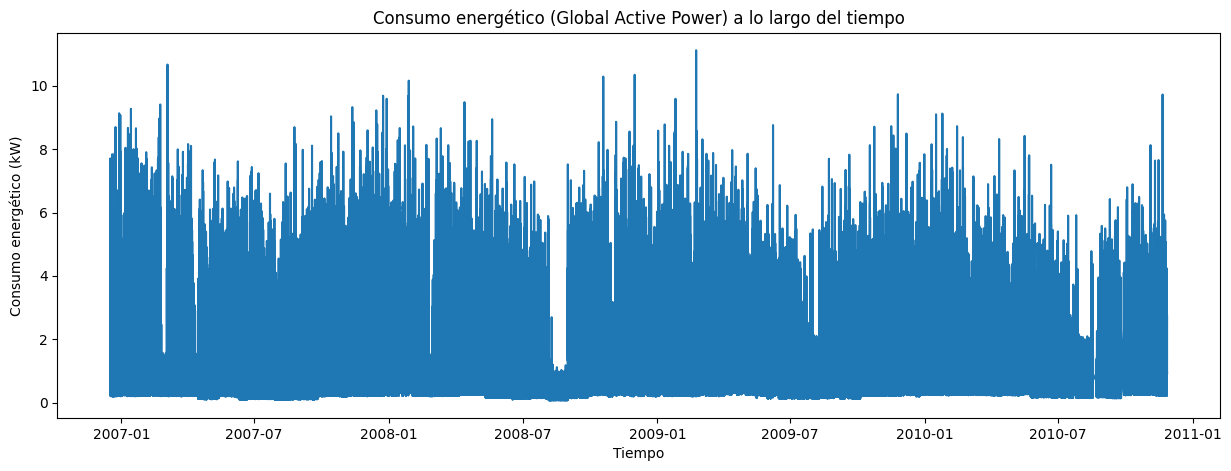

In [50]:
plt.figure(figsize=(15,5))
plt.plot(df2['datetime'], df2['Global_active_power'])
plt.title('Consumo energético (Global Active Power) a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Consumo energético (kW)')
plt.show()


#### 11.1 Interpretacion Inicial.
El gráfico de consumo energético (Global Active Power) a lo largo del tiempo muestra un patrón estacional claro, con mayores niveles de consumo durante los meses fríos y una reducción consistente en los meses cálidos.

Este comportamiento se repite de forma similar año a año, lo que sugiere una estacionalidad fuerte asociada a factores climáticos (uso de calefacción y mayor demanda energética en invierno).

No se observa una tendencia global creciente o decreciente en el consumo a lo largo del período analizado, indicando que el nivel medio de consumo se mantiene relativamente estable en el tiempo.

Adicionalmente, se identifican caídas sostenidas del consumo en periodos específicos (por ejemplo, septiembre de 2008 y septiembre de 2010), que podrían corresponder a eventos atípicos como ausencias prolongadas, fallas de medición o cambios temporales en el patrón de uso, y que justifican un análisis más detallado.

--------------------------------------------------

### 12. Muestreo temporal del consumo energetico (reducimos ruido y mostramos el patron real)
re-muestreo diario.

In [12]:
# Asegurar que Datetime sea el índice
df2 = df2.set_index('datetime')

# Re-muestreo diario (promedio)
daily_consumption = df2['Global_active_power'].resample('D').mean()


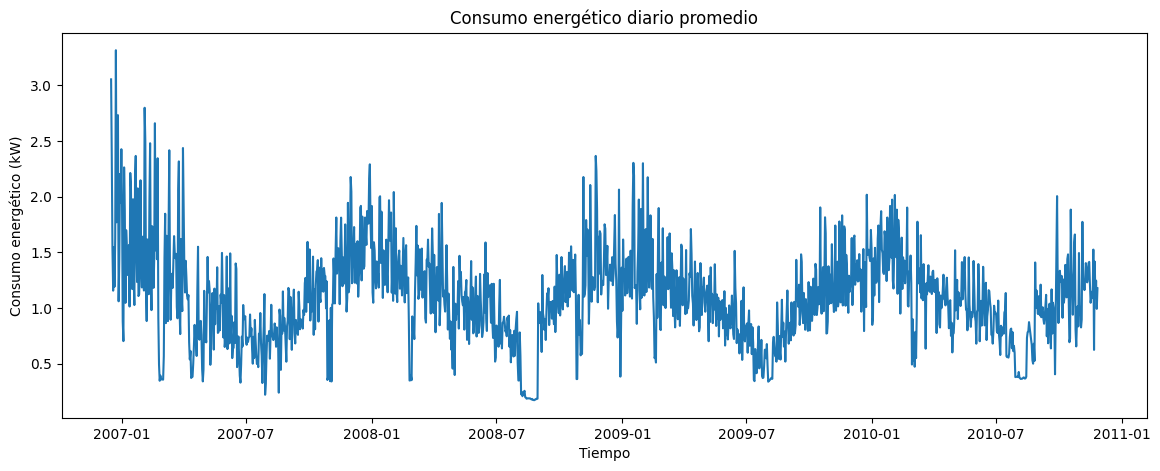

In [8]:
plt.figure(figsize=(14, 5))

plt.plot(
    daily_consumption.index,
    daily_consumption.values
)

plt.xlabel("Tiempo")
plt.ylabel("Consumo energético (kW)")
plt.title("Consumo energético diario promedio")
plt.show()


#### 12.1 Interpretacion Inicial
El gráfico del consumo energético diario promedio muestra un patrón estacional consistente, con mayores niveles de consumo durante los meses fríos y una disminución durante los meses más cálidos, repitiéndose de forma similar año tras año.

No se observa una tendencia creciente o decreciente significativa a largo plazo, lo que sugiere que el consumo se mantiene estable en el tiempo, condicionado principalmente por la estacionalidad.

A nivel diario, se evidencia una alta variabilidad intra-estacional, ya que existen días de bajo consumo durante meses fríos y días de consumo elevado en meses cálidos, lo que indica que factores adicionales influyen en el consumo diario.

Finalmente, se identifican caídas sostenidas atípicas en septiembre de 2008 y septiembre de 2010, que podrían corresponder a eventos externos o anomalías operativas y justifican un análisis más detallado.

-----------------------------------------------------

### 13. Descomposición de la serie temporal
A partir de la visualización del consumo energético diario promedio, se identificó la presencia de un patrón estacional claro, con repeticiones anuales, así como una ausencia de una tendencia global fuerte en el largo plazo. No obstante, la inspección visual combina simultáneamente varios efectos (estacionalidad, tendencia y variabilidad diaria), lo que dificulta analizar cada componente de forma aislada.

Con el objetivo de entender mejor la estructura subyacente de la serie temporal, el siguiente paso consiste en aplicar una descomposición temporal, separando explícitamente:

- **Tendencia:** evolución general del consumo a lo largo del tiempo.

- **Estacionalidad:** patrones periódicos que se repiten de forma regular.

- **Residuo (ruido):** variaciones no explicadas por la tendencia ni la estacionalidad.

Esta descomposición permitirá:

Confirmar formalmente la estacionalidad observada visualmente.

Evaluar si existe alguna tendencia de fondo no evidente en el gráfico original.

Analizar el comportamiento del residuo, lo cual es clave para detectar anomalías y para la posterior etapa de modelado predictivo.

In [13]:
daily_consumption = df2['Global_active_power'].resample('D').mean()


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [15]:
decomposition = seasonal_decompose(
    daily_consumption,
    model='additive',
    period=365
)


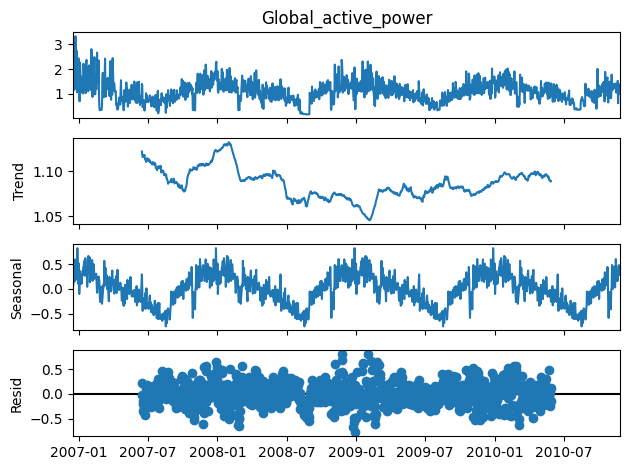

In [16]:
decomposition.plot()
plt.show()


En este paso se aplica una descomposición estacional a la serie de consumo energético diario utilizando un modelo aditivo.

La serie original se separa en tres componentes:

- **Tendencia**, que captura la evolución general del consumo a largo plazo.
- **Estacionalidad**, que refleja patrones repetitivos anuales (periodo = 365 días).
- **Residuo**, que representa variaciones no explicadas por tendencia ni estacionalidad, incluyendo posibles anomalías.

Esta descomposición permite entender qué parte del consumo se explica por patrones regulares y qué parte corresponde a comportamientos atípicos.



### 13.1 Interpretación de la descomposición temporal

La serie de consumo energético diario promedio (Global_active_power) fue descompuesta en cuatro componentes: serie observada, tendencia, estacionalidad y residuo, utilizando un modelo aditivo con periodicidad anual (365 días).

**1. Serie observada**

Corresponde al consumo energético diario promedio original.
Se observa una alta variabilidad diaria con picos frecuentes, lo que indica que el consumo está influenciado tanto por patrones sistemáticos como por eventos puntuales.

**2. Tendencia**

La componente de tendencia muestra:
Una ligera caída progresiva desde 2007 hasta mediados de 2009.
Posteriormente, una recuperación moderada y cierta estabilización hacia 2010.
Esto sugiere que, más allá de la estacionalidad, el nivel medio de consumo energético no es completamente constante en el tiempo, lo cual es relevante para cualquier enfoque de modelado predictivo.

**3. Estacionalidad**

La componente estacional presenta un patrón:
Claramente repetitivo año a año
Con máximos en meses fríos y mínimos en meses cálidos

Esto confirma de forma estructural lo que ya se intuía en el análisis exploratorio:
el consumo energético está fuertemente influenciado por factores estacionales, probablemente asociados a climatización y hábitos de uso.

**4. Residuo**

El residuo representa la parte del consumo no explicada por tendencia ni estacionalidad:

- Está centrado alrededor de cero

- No muestra un patrón claro

- Contiene picos positivos y negativos aislados

Esto indica:

- La descomposición captura adecuadamente la estructura principal de la serie.

- Los residuos pueden interpretarse como eventos atípicos, variabilidad operativa o ruido.

**Conclusión de esta etapa**

La descomposición temporal confirma que:

El consumo energético tiene una estructura estacional fuerte

Existe una tendencia subyacente que no debe ignorarse

Queda una componente residual que podría ser relevante para:

detección de anomalías

mejora de modelos predictivos

-----------------------------------

## Próximo paso: Análisis estacional y preparación para el modelado
A partir de la descomposición temporal, se confirma la presencia de una estacionalidad anual y una tendencia no constante. 
En el siguiente paso se profundizará en el análisis estacional mediante agregaciones temporales (mensuales y/o semanales) y se prepararán los datos para el modelado predictivo, evaluando transformaciones, selección de variables y estrategias de validación temporal.


------------------------------------------

### 14. Agregación mensual del consumo energético

La agregación mensual suaviza la variabilidad diaria y permite observar con mayor claridad la evolución del consumo energético a lo largo del tiempo. 
Se confirma un patrón estacional anual consistente, con mayores niveles de consumo en meses fríos y reducciones en meses cálidos.


In [17]:
monthly_consumption = daily_consumption.resample('ME').mean()


#### 14.1 Grafico

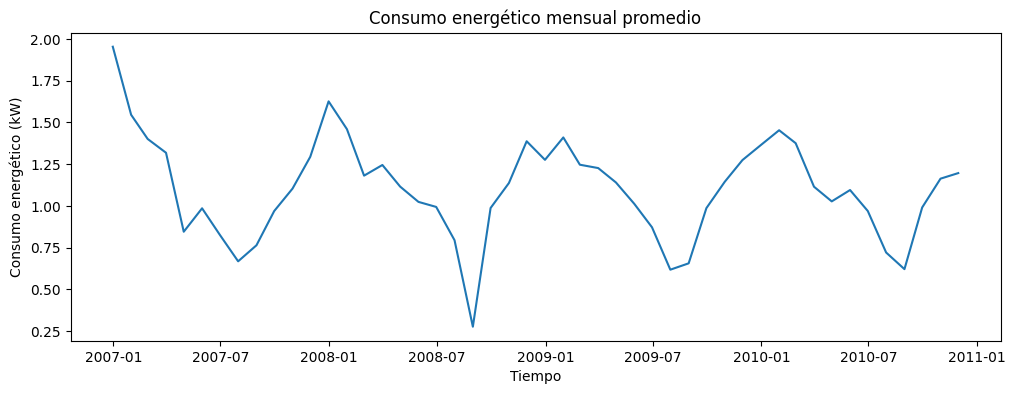

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(monthly_consumption.index, monthly_consumption.values)
plt.title('Consumo energético mensual promedio')
plt.xlabel('Tiempo')
plt.ylabel('Consumo energético (kW)')
plt.show()


### 15. Agregación Semanal del consumo energetico

La agregación semanal permite reducir el ruido diario manteniendo suficiente resolución temporal.
Se observan patrones estacionales similares a los mensuales, pero con mayor sensibilidad a cambios de corto plazo.


In [18]:
weekly_consumption = daily_consumption.resample('W').mean()


#### 15.1 Grafico

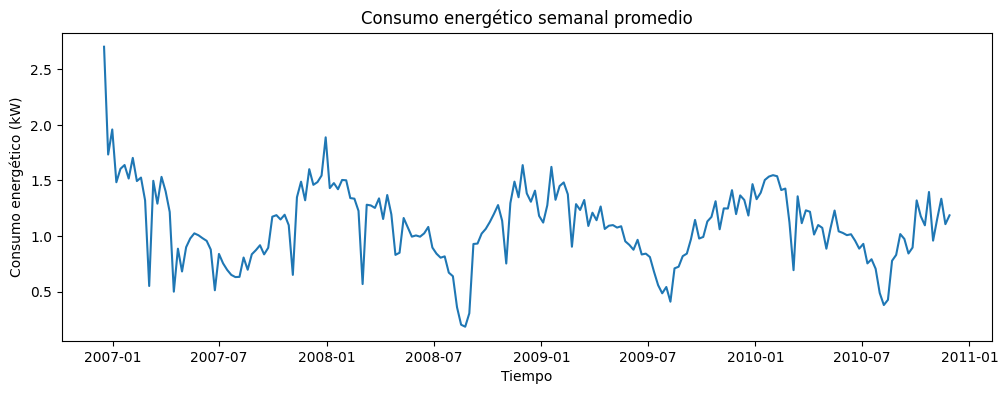

In [65]:
plt.figure(figsize=(12, 4))
plt.plot(weekly_consumption.index, weekly_consumption.values)
plt.title('Consumo energético semanal promedio')
plt.xlabel('Tiempo')
plt.ylabel('Consumo energético (kW)')
plt.show()


-----------------------------------------

### 16. Conclusiones de la agregación temporal

La agregación diaria, semanal y mensual confirma que el consumo energético presenta una fuerte estacionalidad anual y una tendencia subyacente.
La agregación temporal se utiliza como un paso de preparación para el modelado predictivo, ya que reduce el ruido diario, resalta patrones estructurales como la tendencia y la estacionalidad, y permite entrenar modelos más estables e interpretables. En las siguientes secciones se evaluará el comportamiento del consumo a distintas escalas temporales como base para la construcción de modelos de predicción.

------------------------------------------------

### 17. Definición del problema de modelado

El objetivo del modelo es predecir el consumo energético promedio mensual (`Global_active_power`) a partir de patrones históricos observados en la serie temporal.

Se utiliza una agregación mensual con el fin de:
- reducir la variabilidad diaria,
- capturar de forma clara la estacionalidad anual,
- construir un modelo interpretable y estable.


#### 17.1 Agregación temporal mensual

Luego de analizar el consumo energético a nivel diario y observar un patrón estacional consistente, se decide agregar la serie temporal a nivel mensual.

Esta decisión se toma con los siguientes objetivos:

- Reducir la variabilidad diaria y el ruido de corto plazo.

- Resaltar tendencias y patrones estacionales de mediano y largo plazo.

- Preparar los datos para etapas posteriores de modelado predictivo, donde una frecuencia mensual resulta más estable e interpretable.

- Facilitar la comparación entre distintos períodos del año.



In [19]:
monthly_consumption = daily_consumption.resample('ME').mean()


In [17]:
monthly_consumption.head()


datetime
2006-12-31    1.953760
2007-01-31    1.546086
2007-02-28    1.401211
2007-03-31    1.318609
2007-04-30    0.845583
Freq: ME, Name: Global_active_power, dtype: float64

#### 17.2 Análisis exploratorio del consumo energético mensual

En esta sección se analiza el comportamiento del consumo energético promedio a nivel mensual.
El objetivo es evaluar tendencias, estacionalidad y posibles anomalías en una escala temporal más estable, reduciendo la variabilidad diaria observada previamente.

Este análisis servirá como base para la selección del enfoque de modelado predictivo.

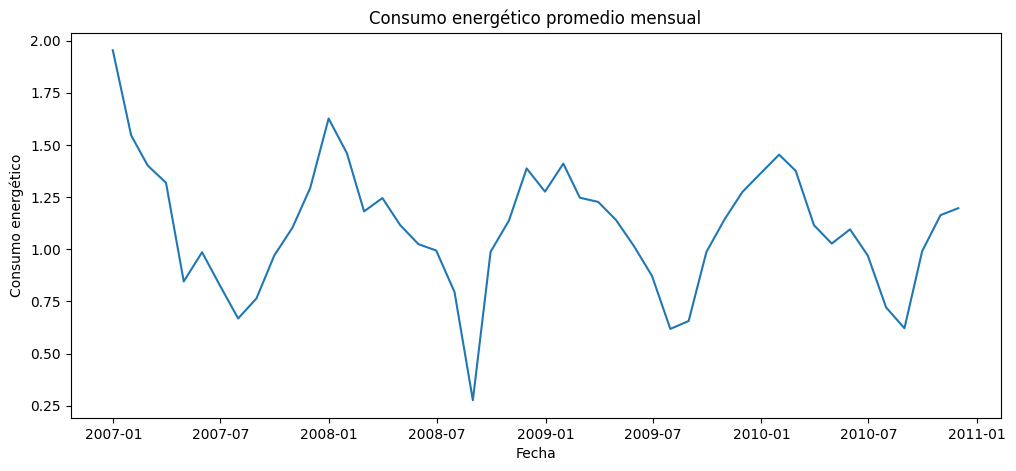

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_consumption.index, monthly_consumption.values)
plt.title('Consumo energético promedio mensual')
plt.xlabel('Fecha')
plt.ylabel('Consumo energético')
plt.show()


#### 17.3 Interpretacion
El consumo energético promedio mensual presenta un patrón estacional claro, con mayores niveles de consumo durante los meses fríos y una disminución consistente en los meses cálidos, repitiéndose de forma relativamente estable año a año.

No se observa una tendencia creciente o decreciente pronunciada a largo plazo, lo que sugiere un comportamiento globalmente estable en el tiempo, más allá de las fluctuaciones estacionales.

Se identifica una caída atípica pronunciada en septiembre de 2008, que se mantiene visible incluso tras la agregación mensual, lo que sugiere la posible ocurrencia de un evento excepcional o una anomalía en los datos.

En contraste, la disminución observada en septiembre de 2010 pierde relevancia al agregarse mensualmente, indicando que podría tratarse de una fluctuación de corto plazo más que de una anomalía estructural.

- La serie presenta estacionalidad clara, estabilidad global y dependencia temporal, lo que la hace adecuada para modelado predictivo. Las anomalías observadas son puntuales y no comprometen la estructura general del proceso

#### 17.4 Preparación para modelado: variables rezagadas

El análisis exploratorio mostró que el consumo energético presenta dependencia temporal y estacionalidad clara.
Dado que el consumo actual depende del comportamiento pasado, se incorporan variables rezagadas (lags) para capturar esta memoria temporal.

Estas variables permiten transformar la serie temporal en un problema de aprendizaje supervisado, donde el modelo utiliza valores históricos del consumo para predecir valores futuros.

#### 17.5 Convertimos la serie mensual a Dataframe

In [20]:
df_model = monthly_consumption.to_frame(name='consumption')


#### 17.6 Creamos variables rezagadas

In [21]:
df_model['lag_1'] = df_model['consumption'].shift(1)
df_model['lag_12'] = df_model['consumption'].shift(12)


#### 17.7 Se eliminan filas con valores nulos creados por Lags

In [22]:
df_model = df_model.dropna()


#### 17.8 Verificamos resultados

In [23]:
df_model.head()


,consumption,lag_1,lag_12
datetime,,,
2007-12-31,1.626470,1.294493,1.953760
2008-01-31,1.459987,1.626470,1.546086
2008-02-29,1.181467,1.459987,1.401211
2008-03-31,1.245345,1.181467,1.318609
2008-04-30,1.115972,1.245345,0.845583


#### 17.9 Justificación de las variables rezagadas

Dado que el consumo energético presenta una dependencia temporal clara (observada en los análisis diarios y mensuales), es necesario incorporar información del pasado para permitir la construcción de modelos predictivos.

Para este propósito, se crean variables rezagadas (lag features) que representan:

El consumo del mes inmediatamente anterior (lag_1), capturando la inercia de corto plazo.

El consumo del mismo mes del año anterior (lag_12), capturando patrones estacionales anuales.

Estas variables permiten que el modelo aprenda cómo el comportamiento pasado del consumo influye en los valores futuros, transformando la serie temporal en una estructura apta para modelos supervisados.

--------------------------------------------------------------

### 18. Separación de datos para modelado temporal

Para evaluar correctamente el desempeño de los modelos predictivos, los datos se dividen en conjuntos de entrenamiento y prueba respetando el orden temporal de la serie.

El conjunto de entrenamiento contiene observaciones históricas utilizadas para ajustar el modelo, mientras que el conjunto de prueba representa períodos futuros no vistos, permitiendo una evaluación realista del poder predictivo.

In [24]:
# Se define punto de corte (80% entrenamiento, 20% prueba)
split_index = int(len(df_model) * 0.8)

train = df_model.iloc[:split_index]
test = df_model.iloc[split_index:]


#### 18.1 Análisis de autocorrelación (ACF)
Se analiza la función de autocorrelación para evaluar la dependencia temporal del consumo energético. La presencia de autocorrelación significativa en varios rezagos confirma que los valores pasados contienen información relevante para predecir valores futuros, lo que valida el uso de variables rezagadas y modelos de series temporales.

<Figure size 1000x400 with 0 Axes>

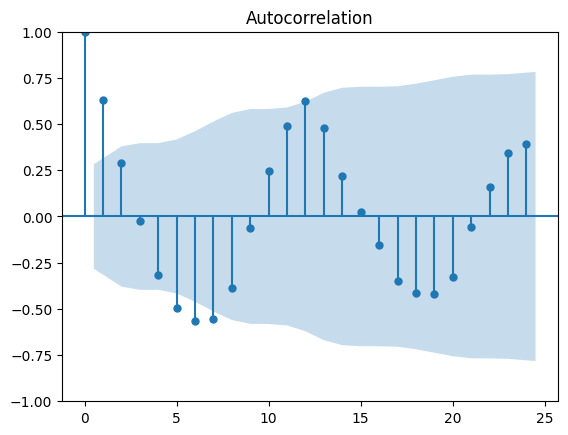

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(monthly_consumption.dropna(), lags=24)
plt.show()


#### 18.2 Interpretacion
El análisis de autocorrelación (ACF) muestra una fuerte dependencia temporal del consumo energético. Se observa una correlación significativa en el primer rezago, lo que indica que el consumo mensual está fuertemente influenciado por el mes anterior.

Asimismo, se identifica una correlación positiva alrededor del rezago 12, confirmando la presencia de estacionalidad anual. Estos resultados justifican el uso de variables rezagadas y modelos predictivos basados en información histórica.

- Dado que el consumo energético presenta dependencia temporal, se crean variables rezagadas que permiten incorporar información de periodos anteriores como variables explicativas para modelos predictivos

-----------------------------------

### 19. Preparacion de los datos para el modelo.
En esta etapa se definen las variables que serán utilizadas por el modelo de regresión lineal.
La variable objetivo es el consumo energético mensual **consumption**.
Como variables explicativas se utilizan rezagos temporales:

**lag_1:** consumo del mes anterior.

**lag_12:** consumo del mismo mes del año anterior.

Los datos se separan en conjuntos de entrenamiento y prueba, respetando el orden temporal..

In [26]:
X_train = train[['lag_1', 'lag_12']]
y_train = train['consumption']

X_test = test[['lag_1', 'lag_12']]
y_test = test['consumption']


###     20. Entrenamiento del modelo 
Se entrena un modelo de regresión lineal utilizando los datos de entrenamiento, con el objetivo de capturar la relación entre el consumo actual y los valores históricos.

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 21. Generación de predicciones
Una vez entrenado el modelo, se generan predicciones sobre el conjunto de prueba, 
utilizando los valores históricos de consumo como variables explicativas

In [28]:
y_pred = model.predict(X_test)


#### 21.1 Comparacion de resultados.
Se construye una tabla de comparación entre el consumo real y el consumo estimado
por el modelo para evaluar visualmente su comportamiento.


In [29]:
results = test.copy()
results['prediction'] = y_pred

results.head()


,consumption,lag_1,lag_12,prediction
datetime,,,,
2010-04-30,1.027280,1.115269,1.140665,1.116287
2010-05-31,1.095298,1.027280,1.012824,1.020062
2010-06-30,0.969630,1.095298,0.872142,0.945893
2010-07-31,0.721111,0.969630,0.618191,0.764198
2010-08-31,0.621408,0.721111,0.656203,0.739950


-------------------------------------

### 22. Visualizacion Consumo Real Vs Predicho
Se visualiza la serie real frente a las predicciones del modelo para evaluar
su capacidad de capturar la dinámica temporal del consumo energético.


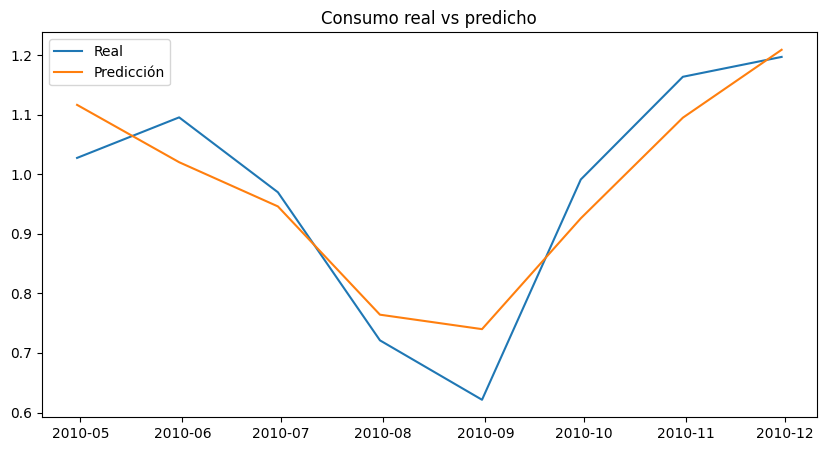

In [35]:
plt.figure(figsize=(10,5))
plt.plot(results.index, results['consumption'], label='Real')
plt.plot(results.index, results['prediction'], label='Predicción')
plt.legend()
plt.title('Consumo real vs predicho')
plt.show()


#### 22.1 Interpretacion
El gráfico de comparación entre el consumo real y el consumo predicho muestra que el modelo de regresión lineal con variables rezagadas logra capturar adecuadamente la dinámica general del consumo energético mensual.

Se observa que las predicciones siguen de forma consistente la tendencia del consumo real, reproduciendo correctamente los períodos de aumento y disminución a lo largo del tiempo. El modelo mantiene el mismo orden de magnitud que los valores observados, lo que indica que no existen desviaciones estructurales ni errores sistemáticos graves.

Las discrepancias visibles entre los valores reales y predichos son moderadas y se concentran principalmente en puntos donde el consumo presenta cambios más abruptos, lo cual es esperable dado que el modelo utiliza únicamente información histórica del consumo (rezagos) y asume una relación lineal.

En conjunto, el gráfico sugiere que el modelo es capaz de explicar una parte significativa de la variabilidad temporal del consumo energético, constituyendo un modelo base sólido, interpretable y adecuado como punto de partida para comparaciones con enfoques más simples (baseline) o modelos más complejos en etapas posteriores.

----------------------------------------------------

### 23. Evaluacion cuantitativa
Se calculan métricas de error para evaluar el desempeño del modelo. 
Estas métricas permiten cuantificar qué tan lejos están las predicciones
del consumo real.


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse


(0.0619289714971334, np.float64(0.06996670413638956))

#### 23.1 interpretacion
Para evaluar el desempeño del modelo de regresión lineal con variables rezagadas, se calcularon métricas cuantitativas sobre el conjunto de prueba, comparando los valores reales de consumo energético con las predicciones generadas por el modelo.

Las métricas obtenidas fueron:

MAE (Mean Absolute Error) ≈ 0.062

RMSE (Root Mean Squared Error) ≈ 0.070

El MAE indica que, en promedio, las predicciones del modelo difieren del valor real de consumo en aproximadamente 0.06 unidades, lo que representa un error bajo en relación con el rango típico de los valores de consumo observados.

Por su parte, el RMSE, al penalizar más fuertemente los errores grandes, presenta un valor ligeramente superior al MAE, lo cual sugiere la presencia de algunas discrepancias puntuales, pero sin errores extremos que comprometan la estabilidad del modelo.

En conjunto, estas métricas confirman lo observado visualmente: el modelo presenta un desempeño consistente, captura adecuadamente la estructura temporal del consumo y genera predicciones razonablemente precisas. Si bien no se trata de un modelo optimizado al máximo, cumple correctamente su rol como modelo base interpretable, adecuado para análisis exploratorios y como referencia para futuras mejoras.

-------------------------------------------------

### 24. Evaluación del modelo de regresion lineal con regazos

El modelo de regresión lineal con rezagos muestra un buen desempeño general.
Las predicciones mantienen el mismo orden de magnitud que los valores reales
y capturan adecuadamente las subidas y bajadas del consumo mensual.

Las métricas de error indican que el error promedio es bajo en relación con
el nivel de consumo observado, lo que sugiere que el modelo es estable y
adecuado como modelo base para este problema.


----------------------------------------------

### 25. Comparación Modelo de Regresion Lineal contra modelo baseline (naive)
Este modelo “predice” usando únicamente el consumo del mes anterior.


#### 25.1 Generando las predicciones baseline

In [32]:
test = test.copy()
test['baseline_prediction'] = test['lag_1']
##test.loc[:, 'baseline_prediction'] = test['lag_1']

#### 25.2 Evaluación cuantitativa del baseline
Usamos las mismas métricas para ser justos:

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_baseline = mean_absolute_error(
    test['consumption'],
    test['baseline_prediction']
)

rmse_baseline = np.sqrt(
    mean_squared_error(
        test['consumption'],
        test['baseline_prediction']
    )
)

mae_baseline, rmse_baseline


(0.1506568618622665, np.float64(0.18279888051840215))

#### 25.3 Interpretacion Modelo Lineal Vs Baseline(naive)
A diferencia del modelo baseline, el modelo de regresión lineal requiere un proceso de entrenamiento previo. Durante esta etapa, el modelo aprende la relación entre las variables rezagadas y el consumo energético, estimando coeficientes que luego se utilizan para generar predicciones sobre datos no vistos.

En cambio, el modelo baseline no aprende patrones, sino que utiliza una regla simple: asumir que el consumo futuro será igual al consumo del período anterior.

Como punto de referencia, se implementó un modelo baseline naive, que asume que el consumo energético de un mes es igual al consumo del mes anterior. Este enfoque no requiere entrenamiento y representa el desempeño mínimo aceptable para un modelo predictivo en series temporales.

Se evaluó el baseline sobre el mismo conjunto de prueba, utilizando las métricas MAE y RMSE. Los resultados muestran que el modelo de regresión lineal con variables rezagadas (lag_1 y lag_12) presenta errores menores que el baseline, lo que indica una mejora real en la capacidad predictiva.

Esta comparación confirma que el modelo propuesto no solo captura la dependencia temporal básica, sino que también incorpora información estacional relevante, aportando valor frente a una predicción ingenua.


-----------------------------------------------------

### 26. Transición hacia un modelo específico de series temporales

Hasta este punto del análisis, se ha trabajado de forma progresiva sobre el consumo energético agregado a nivel mensual, abordando las principales características de una serie temporal:

Se identificó un patrón estacional claro, con mayor consumo en meses fríos y menor consumo en meses cálidos.

Se observó una tendencia global relativamente estable, con la presencia de anomalías puntuales.

Se confirmó la dependencia temporal del consumo, evidenciada tanto en la exploración visual como en el análisis de autocorrelación (ACF).

A partir de estos hallazgos, se construyó un modelo de regresión lineal con variables rezagadas, el cual permitió capturar parte de la dinámica temporal del consumo y mejorar el desempeño frente a un modelo baseline (naive). Este modelo sirvió como un primer enfoque explicativo y comparativo, validando que el consumo pasado aporta información relevante para la predicción.

Sin embargo, la regresión lineal con rezagos presenta una limitación importante: no modela explícitamente la estructura temporal de la serie, sino que la incorpora de manera indirecta a través de variables creadas manualmente. Dado que el análisis previo ha demostrado la presencia simultánea de:

autocorrelación,

estacionalidad anual,

y una estructura temporal consistente,

resulta adecuado avanzar hacia un modelo diseñado específicamente para series temporales.

En este contexto, el siguiente paso del proyecto será la implementación de un modelo SARIMA (Seasonal ARIMA), el cual permite modelar de forma explícita:

la dependencia entre observaciones pasadas,

la estacionalidad del consumo energético,

y los componentes autoregresivos y de promedio móvil de la serie.

Este modelo será evaluado y comparado con los enfoques anteriores con el objetivo de determinar si aporta una mejora significativa en la capacidad predictiva, manteniendo un equilibrio entre desempeño, interpretabilidad y complejidad. Con ello, se busca cerrar el proyecto con un enfoque sólido y coherente desde el punto de vista analítico.

-----------------------------------------------------

### 27. Definimos Train y Test

En este proyecto, el DataFrame df_model ya contiene la serie de consumo energético agregada mensualmente y preparada para modelado.
Por este motivo, se reutiliza directamente este objeto, evitando transformaciones redundantes y manteniendo consistencia con los modelos previos.

In [35]:
# Definir tamaño del conjunto de entrenamiento (80%)
train_size = int(len(df_model) * 0.8)


In [36]:
# Separar datos respetando el orden temporal
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

#### 27.1 Evaluación de estacionariedad

Los modelos SARIMA requieren que la serie sea estacionaria o que pueda hacerse estacionaria mediante diferenciación.

Antes de definir los parámetros del modelo, se evalúa formalmente la estacionariedad de la serie de consumo mensual utilizando la prueba de Dickey-Fuller aumentada (ADF).

In [38]:
result = adfuller(train['consumption'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -4.79696063351691
p-value: 5.511873377930781e-05


Dado que el valor p es significativamente menor a 0.05, se rechaza la hipótesis nula de no estacionariedad.

Esto indica que la serie de consumo mensual puede considerarse estacionaria, por lo que es apta para ser modelada directamente mediante modelos SARIMA sin necesidad de aplicar transformaciones adicionales para estabilizar la media.
- *La serie cumple con el supuesto de estacionariedad requerido para SARIMA, por lo que se procede directamente al ajuste del modelo.*

#### 27.2 Definicion Modelo SARIMA
A partir del análisis previo, se define un modelo SARIMA con:

- Componente no estacional para capturar dependencia de corto plazo

- Componente estacional anual (12 meses) para capturar patrones repetitivos

La configuración inicial se elige de forma conservadora, priorizando interpretabilidad y estabilidad del modelo.

In [40]:
sarima_model = SARIMAX(
    train['consumption'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit()


c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


#### 27.3 Prediccion Modelo SARIMA
Una vez entrenado el modelo, se generan predicciones sobre el conjunto de prueba y se comparan con los valores reales.

El desempeño se evalúa utilizando MAE y RMSE, permitiendo una comparación directa con los modelos anteriores.

In [41]:
predictions = sarima_results.predict(
    start=test.index[0],
    end=test.index[-1]
)

mae = mean_absolute_error(test['consumption'], predictions)
rmse = np.sqrt(mean_squared_error(test['consumption'], predictions))

mae, rmse


(0.06576153643145785, np.float64(0.0768220676179391))

#### 27.4 Visualización de resultados del modelo SARIMA

Una vez entrenado el modelo SARIMA y generadas las predicciones sobre el conjunto de prueba, es fundamental evaluar visualmente su desempeño.

La comparación entre el consumo energético real y el consumo predicho permite verificar si el modelo:

Captura correctamente la tendencia general,

Reproduce el patrón estacional,

Responde adecuadamente a subidas y bajadas del consumo.

Esta evaluación visual complementa las métricas cuantitativas (MAE y RMSE) y ayuda a determinar si el modelo es adecuado para describir la dinámica temporal del consumo energético.

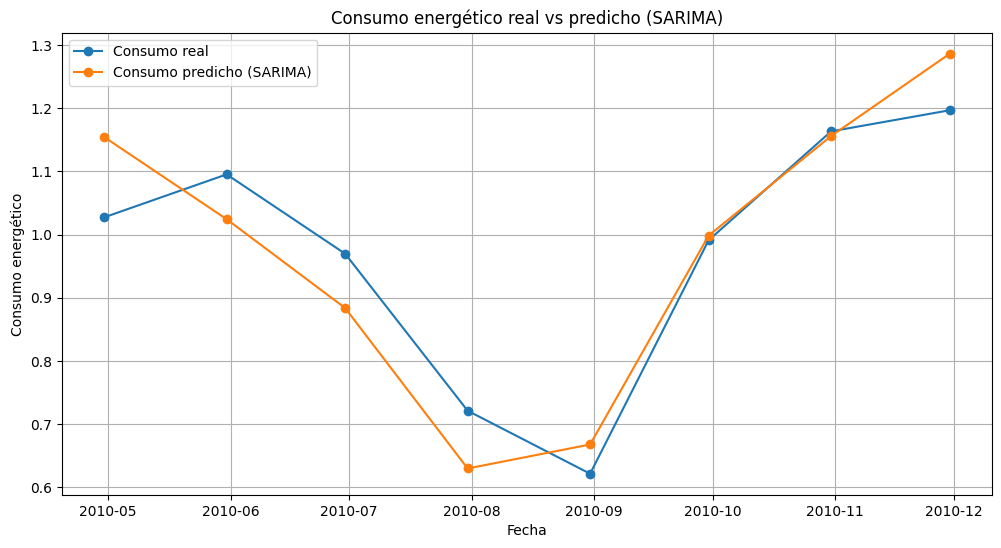

In [43]:
plt.figure(figsize=(12, 6))

plt.plot(test.index, test['consumption'], label='Consumo real', marker='o')
plt.plot(test.index, predictions, label='Consumo predicho (SARIMA)', marker='o')

plt.title('Consumo energético real vs predicho (SARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Consumo energético')
plt.legend()
plt.grid(True)

plt.show()


#### 27.5 Interpretacion grafico
El gráfico compara el consumo energético real con el consumo estimado por el modelo SARIMA durante el período de prueba. Se observa que el modelo logra capturar adecuadamente la tendencia general y la estacionalidad del consumo, reproduciendo tanto las caídas como los aumentos mensuales.

Si bien existen pequeñas diferencias entre los valores reales y los predichos, estas discrepancias son acotadas y no alteran el patrón general, lo que sugiere un buen ajuste del modelo a la dinámica temporal del consumo energético.

-----------------------------------------------

Con la implementación y evaluación del modelo SARIMA, se completa la fase de modelado del proyecto. Los resultados muestran que el consumo energético presenta una estructura temporal clara, con estacionalidad anual y dependencia de valores pasados, lo que permite realizar predicciones razonables a nivel mensual.

A continuación, se sintetizan los principales hallazgos del análisis y se discuten las conclusiones finales, así como posibles líneas de mejora y extensión del modelo

--------------------------------------

### Comparación de modelos y decisión final

Durante el proyecto se evaluaron distintos enfoques de modelado con el objetivo de balancear simplicidad, interpretabilidad y capacidad predictiva.

Como punto de partida, se utilizó un modelo baseline (naive), que asume que el consumo futuro es similar al último valor observado. Este enfoque sirvió como referencia mínima para evaluar si modelos más complejos aportaban valor real.

Posteriormente, se implementó un modelo de regresión lineal con variables rezagadas, incorporando explícitamente la dependencia temporal del consumo. Este modelo permitió capturar relaciones básicas entre periodos consecutivos y ofreció una primera mejora respecto al baseline, además de ser altamente interpretable.

Finalmente, se utilizó un modelo SARIMA, diseñado específicamente para series temporales con patrones estacionales. Este modelo logró representar de forma más completa la estructura temporal del consumo energético, capturando tendencia, estacionalidad y autocorrelación de manera integrada.

Dado su mejor desempeño predictivo y su adecuación al tipo de datos analizados, el modelo SARIMA fue seleccionado como el enfoque final para este proyecto.


### Conclusiones finales

A continuación se sintetizan los principales hallazgos del proyecto, dando respuesta a las preguntas de análisis planteadas al inicio.
#### 1: Patrones temporales del consumo
El análisis temporal del consumo energético evidenció patrones claros y recurrentes a lo largo del tiempo. Se identificó una estacionalidad anual marcada, con mayores niveles de consumo durante los meses más fríos y una disminución sistemática en los meses cálidos.

A nivel mensual, el consumo no muestra una tendencia creciente o decreciente sostenida en el largo plazo, sino un comportamiento estable dominado por ciclos estacionales. Estos patrones se repiten de forma consistente año tras año, lo que sugiere una fuerte dependencia temporal del consumo energético.

#### 2: Variables explicativas y dependencia temporal
Dado el carácter univariado del dataset, se observó que las variables temporales juegan un rol central en la explicación de la variabilidad del consumo energético. En particular, los valores pasados del consumo (rezagos) mostraron una relación significativa con los valores futuros, confirmando la presencia de autocorrelación.

Este comportamiento fue consistente tanto en el análisis exploratorio como en los modelos predictivos, lo que refuerza la idea de que la dinámica del consumo está fuertemente determinada por su propia historia temporal más que por factores externos observables en el dataset.

#### 3: Anomalías y comportamientos atípicos
Durante el análisis exploratorio se detectaron períodos con caídas pronunciadas y sostenidas en el consumo energético, particularmente en determinados meses específicos. Estas anomalías se mantuvieron visibles incluso tras la agregación temporal, lo que sugiere que no se trata de ruido puntual sino de eventos atípicos con impacto real en el consumo.

Si bien el dataset no permite identificar las causas exactas de estos eventos, su consistencia temporal indica que podrían estar asociadas a factores externos o cambios operativos no registrados en los datos.

#### 4: Capacidad predictiva y comparación de modelos
Los resultados del modelado confirmaron que es posible predecir el consumo energético con un nivel de error razonable utilizando únicamente información histórica.

Un modelo de regresión lineal con variables rezagadas permitió establecer una línea base explicable y consistente, mientras que el modelo SARIMA logró capturar de forma más natural la estacionalidad y la dependencia temporal de la serie.

En términos de balance entre precisión e interpretabilidad, el modelo SARIMA ofreció un mejor ajuste global, manteniendo errores acotados y reproduciendo adecuadamente los patrones observados en los datos reales.